# Houses Sales price Prediction

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [30]:
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [31]:
ds = pd.read_csv('kaggle_houseprices_modified.csv')
ds.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,198075.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,199650.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,212325.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,237500.0


In [32]:
# We have 80 predictor features and 1 target variable which is sales price.
ds.shape

(1460, 81)

In [33]:
# We do not have any duplicates.
# Each row contains details of a unqiue house. We have details of a total of 1460 houses. 
ds.duplicated().sum()

0

## Preprocessing

In [34]:
# Storing the features in different arrays according to their type. 
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
               'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'HouseStyle',
               'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
               'Electrical', 'GarageType', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition']
continuous_num = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
              'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'MasVnrArea',
              'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
              'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
              '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']
cat_to_num = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
              'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
              'PoolQC', ] # Are oridinal categorical and will be encoding it to make it numerical.

In [35]:
ds = ds.drop(columns='Id') # Dropping the default index

#### Missing Value Imputation

- Will not be dropping any of the missing value rows as they are very less. 
- Logical NaNs: 'Alley', 'Fence', 'MiscFeature', 'MasVnrType', 'GarageType', 'FireplaceQu' - The missing or NaN values in these features are actual categories. Eg. NaN in Fence means the house has no fence, NaN in Garage means the house has no Garage. 
- Mode: 'Electrical'
- Median: 'LotFrontage', 'MasVnrArea'
- Mean: 'GarageYrBlt'
- Drop: PoolQC

#### Categorical

In [36]:
ds[categorical].isna().sum().sort_values(ascending=False)[:7] / len(ds) / len(ds)*100

MiscFeature    0.065960
Alley          0.064224
Fence          0.055311
GarageType     0.003800
MasVnrType     0.000375
Electrical     0.000047
MSSubClass     0.000000
dtype: float64

In [37]:
logical_nans = ['Alley', 'Fence', 'MiscFeature', 'MasVnrType', 'GarageType', ]
for col in logical_nans:
    ds[col] = ds[col].fillna('NA')
    
ds['Electrical'] = ds['Electrical'].fillna(ds['Electrical'].value_counts().index[0])  # mode
print(ds[categorical].isna().sum().sum())

0


#### Continuous

In [38]:
ds[continuous_num].isna().sum().sort_values(ascending=False)[:5] / len(ds) * 100

LotFrontage     17.739726
GarageYrBlt      5.547945
MasVnrArea       0.547945
HalfBath         0.000000
KitchenAbvGr     0.000000
dtype: float64

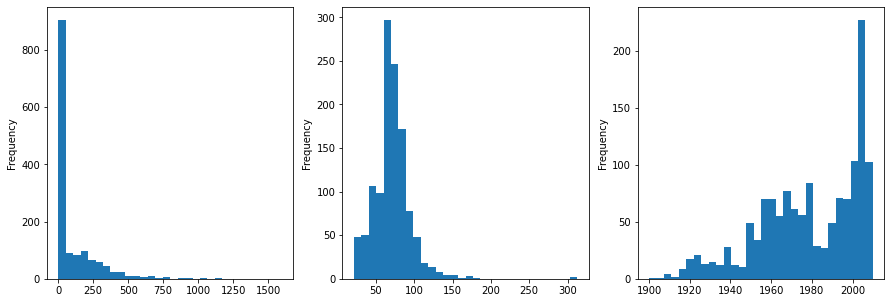

In [39]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ds['MasVnrArea'].plot(kind='hist', bins=30)
plt.subplot(1,3,2)
ds['LotFrontage'].plot(kind='hist', bins=30)
plt.subplot(1,3,3)
ds['GarageYrBlt'].plot(kind='hist', bins=30)
plt.show()
# MasVnrArea and LotFrontage distributions seem to be right skewed. Will go with median imputation for these features. 
# Will use mean value to fill for GarageYrBlt feature.

In [40]:
ds['LotFrontage'] = ds['LotFrontage'].fillna(ds['LotFrontage'].median())
ds['MasVnrArea']  = ds['MasVnrArea'].fillna(ds['MasVnrArea'].median())
ds['GarageYrBlt'] = ds['GarageYrBlt'].fillna(ds['GarageYrBlt'].mean())
print(ds[continuous_num].isna().sum().sum())

0


#### cat-to-num

In [41]:
ds[cat_to_num].isna().sum().sort_values(ascending=False)[:11] / len(ds) * 100

PoolQC          99.520548
FireplaceQu     47.260274
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
ExterQual        0.000000
dtype: float64

In [42]:
logical_nans = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                'BsmtFinType2', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in logical_nans:
    ds[col] = ds[col].fillna('NA')

In [43]:
# Dropping PoolQC feature as it has 99 % missing values
ds.drop(columns = ['PoolQC'], inplace=True)
cat_to_num.remove('PoolQC')

In [44]:
ds[cat_to_num].isna().sum().sum()

0

In [45]:
ds.isna().sum().sum() # All missing values have been filled

0

#### Feature encoding

In [46]:
# Will be using Target encoding for all the categorical features.
target = 'SalePrice'
for col in categorical:
    ds[col] = ds.groupby([col])[target].transform('mean')

In [47]:
# cat_to_num features are ordinal categorical. Hence will be using label encoding. 
for col in cat_to_num:
    print(col, ds[col].unique())

ExterQual ['Gd' 'TA' 'Ex' 'Fa']
ExterCond ['TA' 'Gd' 'Fa' 'Po' 'Ex']
BsmtQual ['Gd' 'TA' 'Ex' 'NA' 'Fa']
BsmtCond ['TA' 'Gd' 'NA' 'Fa' 'Po']
BsmtExposure ['No' 'Gd' 'Mn' 'Av' 'NA']
BsmtFinType1 ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'NA' 'LwQ']
BsmtFinType2 ['Unf' 'BLQ' 'NA' 'ALQ' 'Rec' 'LwQ' 'GLQ']
HeatingQC ['Ex' 'Gd' 'TA' 'Fa' 'Po']
KitchenQual ['Gd' 'TA' 'Ex' 'Fa']
Functional ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
FireplaceQu ['NA' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
GarageFinish ['RFn' 'Unf' 'Fin' 'NA']
GarageQual ['TA' 'Fa' 'Gd' 'NA' 'Ex' 'Po']
GarageCond ['TA' 'Fa' 'NA' 'Gd' 'Po' 'Ex']


In [48]:
grp1 = ['GarageQual', 'GarageCond', 'FireplaceQu', 'KitchenQual', 'HeatingQC', 'BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual']
for col in grp1:
    ds[col] = ds[col].replace({'TA': 3, 'Fa': 2, 'NA': 0, 'Gd': 4, 'Po': 1, 'Ex': 5})
    
for col in ['BsmtFinType1', 'BsmtFinType2']:
    ds[col] = ds[col].replace({'GLQ':6, 'ALQ':5, 'Unf':1, 'Rec':3, 'BLQ':4, 'NA':0, 'LwQ':2})

ds['BsmtExposure'] = ds['BsmtExposure'].replace({'No':1, 'Gd':4, 'Mn':2, 'Av':3, 'NA':0})
ds['Functional'] = ds['Functional'].replace({'Typ':7, 'Min1':6, 'Maj1':3, 'Min2':5, 'Mod':4, 'Maj2':2, 'Sev':1, 'Sal':0})
ds['GarageFinish'] = ds['GarageFinish'].replace({'RFn':2, 'Unf':1, 'Fin':3, 'NA':0})

#### Scaling the features
- Will be using standard scaler as they are less susceptible to outliers. 

In [49]:
scaler = StandardScaler()
ds_scaled = scaler.fit_transform(ds.iloc[:,:-1])

In [50]:
ds_scaled = pd.DataFrame(ds_scaled, columns=ds.iloc[:,:-1].columns)
ds_scaled['SalePrice'] = ds['SalePrice']
ds_scaled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1.296895,0.352365,-0.220875,-0.207142,0.064238,0.212115,-0.735059,-0.03169,0.02618,-0.262034,...,-0.270208,-0.068692,0.464699,0.178837,-0.087688,-0.912029,0.138777,-0.285256,-0.254685,198075.0
1,0.307826,0.352365,0.460320,-0.091886,0.064238,0.212115,-0.735059,-0.03169,0.02618,-1.319499,...,-0.270208,-0.068692,0.464699,0.178837,-0.087688,-1.153920,-0.614439,-0.285256,-0.254685,199650.0
2,1.296895,0.352365,-0.084636,0.073480,0.064238,0.212115,1.137285,-0.03169,0.02618,-0.262034,...,-0.270208,-0.068692,0.464699,0.178837,-0.087688,2.100098,0.138777,-0.285256,-0.254685,212325.0
3,-0.432851,0.352365,-0.447940,-0.096897,0.064238,0.212115,1.137285,-0.03169,0.02618,-0.061931,...,-0.270208,-0.068692,0.464699,0.178837,-0.087688,-0.912029,-1.367655,-0.285256,-0.737003,140000.0
4,1.296895,0.352365,0.641972,0.375148,0.064238,0.212115,1.137285,-0.03169,0.02618,-1.319499,...,-0.270208,-0.068692,0.464699,0.178837,-0.087688,0.374444,0.138777,-0.285256,-0.254685,237500.0


### Baseline Model
- Will be using Gradient boosting algorithm to train our regression model.
- Will use kfold cross validation as we have very less number of data points.

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

In [52]:
X = ds_scaled.drop('SalePrice', axis = 1)
y = ds_scaled['SalePrice']

Parameters = {'learning_rate':np.arange(0.1, 1.1, 0.1), 'n_estimators':np.arange(5, 50, 5), 'max_depth':[1,2,3]}
reg_model = GridSearchCV(XGBRegressor(), Parameters, scoring='neg_mean_squared_error', cv = 10)
reg_model.fit(X, y)

abs(reg_model.best_score_)**0.5

32024.637547572598

- We got an RMSE of 32.024k.
- This is just our baseline model.
- We'll go step by step troubleshooting our model to reduce this loss. 

### Visualisation

- Lets reduce our dimensions to 2 and check if there exists any clusters and outliers using a scatter plot. 
- If there are different clusters then each cluster exhibits a different behaviour, then one model will not be able to give accurate predictions. 

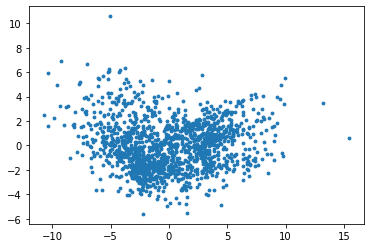

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
vis = pca.fit_transform(ds_scaled.iloc[:, :-1])
plt.scatter(vis[:,0], vis[:,1], s=8)
# No clusters visible.
# It either does not exist or PCA is unable to capture them as the algorithm by default does not preserve the neighbourhoods of
# datapoints.

C:\Users\SHREE KRISHNA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\SHREE KRISHNA\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


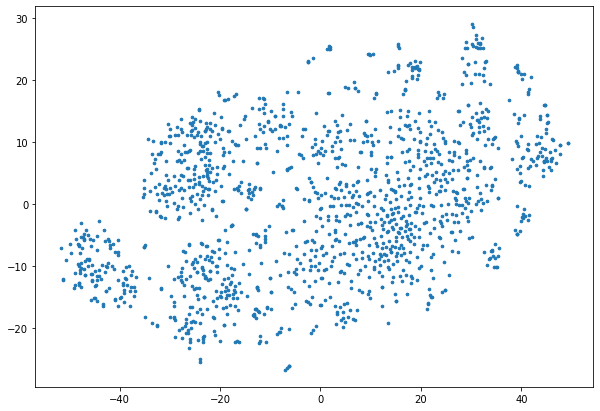

In [54]:
from sklearn.manifold import TSNE

plt.figure(figsize=(10,7))
tsne = TSNE(n_components=2, perplexity=50, random_state = 0)
vis = tsne.fit_transform(ds_scaled.iloc[:, :-1])
plt.scatter(vis[:,0], vis[:,1], s=7)
# We can clearly see 4 to 5 clusters here along with the outliers.

### Outlier Detection and removal

In [56]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

Will be initially fitting the the reduced data set to visualise and get the best parameters which can accurately detect outliers.

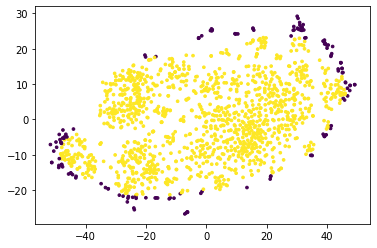

In [57]:
is_outlier = IsolationForest(contamination = 0.1, random_state=0, n_estimators=1000).fit_predict(vis)
plt.scatter(vis[:,0], vis[:,1], s=7, c=is_outlier)
plt.show()
# It is not able to capture outliers in between clusters. 

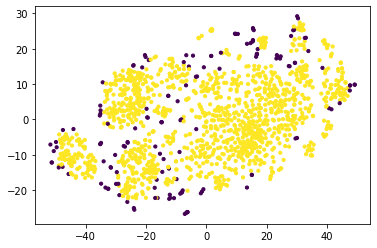

In [58]:
is_outlier = LocalOutlierFactor(n_neighbors=10, contamination=0.1).fit_predict(vis)
plt.scatter(vis[:,0], vis[:,1], s=10, c=is_outlier)
plt.show()
# LOF algorithm is able to capture most of the outliers over here, even in between clusters.

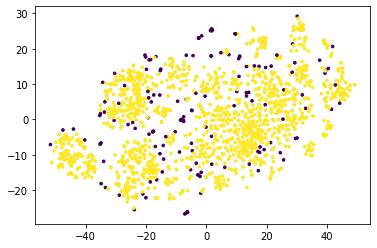

In [59]:
# Fitting the model to the entire data dataset
is_outlier = LocalOutlierFactor(n_neighbors=10, contamination=0.1).fit_predict(ds_scaled.iloc[:, :-1])
plt.scatter(vis[:,0], vis[:,1], s=7, c=is_outlier)
plt.show()

LOF is able to detect a good amount of the outliers when trained on our original scaled data frame. We can use LOF along with Kmeans if kmeans properly seperates clusters. But, if kmeans doesnot work we can go with DBSCAN which not only gives us good clusters, but also seperates outliers. 

### Clustering

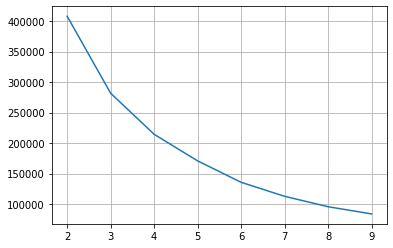

In [60]:
from sklearn.cluster import KMeans

elbow = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vis)
    elbow.append(kmeans.inertia_)
    
plt.plot(range(2,10), elbow)
plt.grid()
plt.show()

> I can only see 2 elbows but cannot draw any proper conclusion from this plot.

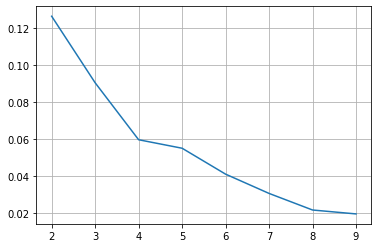

In [61]:
from sklearn.metrics import silhouette_score

elbow = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vis)
    elbow.append(silhouette_score(ds_scaled.iloc[:, :-1], kmeans.labels_))
    
plt.plot(range(2,10), elbow)
plt.grid()
plt.show()

> We can see elbows at 4 and 5. Lets go with 4(Decision made using the scatterplot of embeddings.)

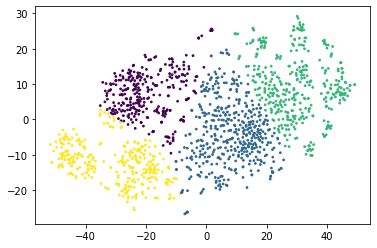

In [62]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(vis)
# kmeans.fit(vis)

plt.scatter(vis[:,0], vis[:,1], s=3, c=kmeans.labels_)
# Kmeans is failing to seperate the clusters properly. We'll have to go with another algorithm.

<function matplotlib.pyplot.colorbar(mappable=None, cax=None, ax=None, **kw)>

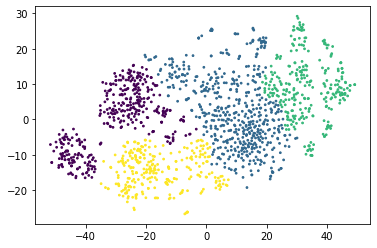

In [63]:
from sklearn.cluster import AgglomerativeClustering
aglo = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward').fit(vis)
plt.scatter(vis[:,0], vis[:,1], s=3, c=aglo.labels_)
plt.colorbar
# This is still not able to seperate the 4 clusters properly.

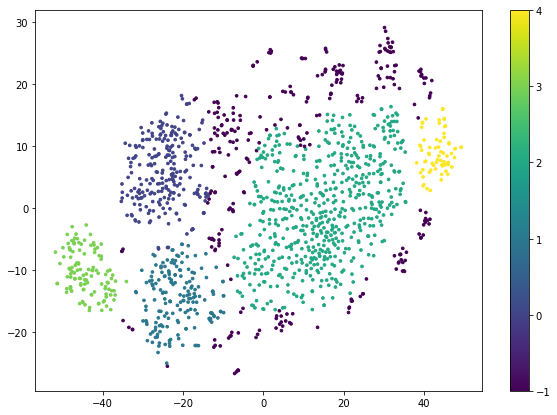

In [64]:
from sklearn.cluster import DBSCAN
dbsc = DBSCAN(eps = 5.5, min_samples = 45).fit(vis)
plt.figure(figsize=(10,7))
plt.scatter(vis[:,0], vis[:,1], s=7, c=dbsc.labels_)
plt.colorbar()
# DBSCAN was not only able to get seperate 5 clusters but also detected the outliers very well.

In [79]:
pd.Series(dbsc.labels_).value_counts()

 2    578
-1    291
 0    231
 1    176
 3    115
 4     69
dtype: int64

In [65]:
# Lets find out if these clusters are able to differentiate themselves on the basis of mean sales price. 
print("Global Mean:", ds.SalePrice.mean())

for cluster in pd.Series(dbsc.labels_).unique():
    if cluster == -1:
        continue    
    print(cluster, ds.loc[dbsc.labels_==cluster]['SalePrice'].mean())
# We can see that some clusters like 3 and 4 have means which are nowhere near to global mean. Hence the justification of 
# cluster existence. Also, cluster 0 and 1 appear to be same. 

Global Mean: 193784.76647260276
0 220208.3803030303
2 157425.64048442908
1 228327.91477272726
3 414606.18260869564
4 62848.260869565216


In [66]:
fi = pd.DataFrame()
fi['features'] = ds.columns[:-1]
fi['importance'] = reg_model.best_estimator_.feature_importances_
fi.sort_values(by='importance', ascending=False).head(10)

,features,importance
60,GarageCars,0.248633
16,OverallQual,0.187564
29,BsmtQual,0.137954
76,SaleType,0.078377
52,KitchenQual,0.035584
11,Neighborhood,0.034467
57,GarageType,0.029253
62,GarageQual,0.029243
63,GarageCond,0.025578
53,TotRmsAbvGrd,0.023356


In [67]:
# Lets see how these clusters differenciate  the top features
temp = ds.groupby(dbsc.labels_)['OverallQual', 'BsmtQual', 'GarageCars', 'KitchenQual', 'SalePrice'].mean()
temp
# We can see that wherever the saleprice mean is higher, other feature means are also reportedly higher.

C:\Users\SHREE KRISHNA\AppData\Local\Temp\ipykernel_28480\687119298.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = ds.groupby(dbsc.labels_)['OverallQual', 'BsmtQual', 'GarageCars', 'KitchenQual', 'SalePrice'].mean()


,OverallQual,BsmtQual,GarageCars,KitchenQual,SalePrice
-1,5.731959,3.000000,1.735395,3.274914,167916.319588
0,7.112554,4.056277,2.212121,3.913420,220208.380303
1,7.272727,4.198864,2.289773,4.056818,228327.914773
2,5.401384,3.159170,1.508651,3.221453,157425.640484
3,7.617391,4.426087,2.513043,4.269565,414606.182609
4,4.579710,3.043478,0.000000,2.942029,62848.260870


In [69]:
ds.groupby(dbsc.labels_)['OverallQual', 'BsmtQual', 'GarageCars', 'KitchenQual', 'SalePrice'].mean().corr().iloc[:-1,-1]
#High positive correlation between sale price and top features means for each cluster can be observed here.

C:\Users\SHREE KRISHNA\AppData\Local\Temp\ipykernel_28480\482414259.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ds.groupby(dbsc.labels_)['OverallQual', 'BsmtQual', 'GarageCars', 'KitchenQual', 'SalePrice'].mean().corr().iloc[:-1,-1]


OverallQual    0.868947
BsmtQual       0.831697
GarageCars     0.822839
KitchenQual    0.889942
Name: SalePrice, dtype: float64

##### Hence, we were able to get proper clusters even without using target variable. The only complication over here is DBSCAN is non-deployable. We can tackle 

### Baseline w/o outliers

In [70]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

c = dbsc.labels_!=-1
X = ds_scaled[c].iloc[:, :-1].values
y = ds_scaled[c].iloc[:, -1].values

kf = KFold(10)
Parameters = {'learning_rate':np.arange(0.1, 1.1, 0.1), 'n_estimators':np.arange(5, 50, 5), 'max_depth':[1,2,3]}
p_grid = ParameterGrid(Parameters)

y_true, y_pred = np.array([]), np.array([])
for train_index, test_index in kf.split(X):
    best_score = -float('inf')
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    for params in p_grid:
        estimator = XGBRegressor(**params)
        estimator.fit(X_train, y_train)
        r2_score = estimator.score(X_test, y_test)
        if r2_score > best_score:
            best_score = r2_score
            predictions = estimator.predict(X_test)
    y_true = np.append(y_true, y_test)
    y_pred = np.append(y_pred, predictions)

mse(y_true, y_pred)**0.5, mape(y_true, y_pred)

(29442.306431872265, 0.104044176221347)

Since, we removed the outliers our rmse fell from 32k to 29k which is good but still we are building one model for all the clusters which does not help. We can improve by buidling individual models for each cluster. 

### Cluster wise training

In [71]:
rmses = []
mapes = []
n = 0

Parameters = {'learning_rate':np.arange(0.1, 1.1, 0.1), 'n_estimators':np.arange(5, 50, 5), 'max_depth':[1,2,3]}
p_grid = ParameterGrid(Parameters)

for cluster in range(5):
    X = ds_scaled.iloc[:, :-1].values[dbsc.labels_==cluster]
    y = ds_scaled['SalePrice'].values[dbsc.labels_==cluster]
    kf = KFold(n_splits=10)

    y_true, y_pred = np.array([]), np.array([])
    for train_index, test_index in kf.split(X):
        best_score = -float('inf')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        for params in p_grid:
            estimator = XGBRegressor(**params)
            estimator.fit(X_train, y_train)
            r2_score = estimator.score(X_test, y_test)
            if r2_score > best_score:
                best_score = r2_score
                predictions = estimator.predict(X_test)
        y_true = np.append(y_true, y_test)
        y_pred = np.append(y_pred, predictions)
    rmses.append(mse(y_true, y_pred)*len(y_true)**0.5)
    mapes.append(mape(y_true, y_pred)*len(y_true))
    
    n+=len(y_true)

    print(cluster, 'rmse :', mse(y_true, y_pred)**0.5, 'mape:',mape(y_true, y_pred))
    
print(sum(rmses)/n, sum(mapes)/n)

0 rmse : 21888.1354288917 mape: 0.06564279758085707
1 rmse : 19770.068880479266 mape: 0.06323507508954768
2 rmse : 19166.02058782008 mape: 0.09737135560348298
3 rmse : 67799.72199747572 mape: 0.11747791101091062
4 rmse : 10025.726106055286 mape: 0.14583397720876784
61102095.78963352 0.09080069049564692


##### Inference from above results
- Combined MAPE has improved significantly.
- As behaviour of each cluster is different we cannot just use RMSE to compare the compare losses or errors. Eg. Eventhough RMSE is high in 3rd cluster we can see that MAPE is 11% which is almost similar to the losses of other cluster. 
- As observed before, cluster 0, 1, 2 appear to be similar and we dont see much difference in the RMSEs too. We can club these to reduce our model complexity.

### Merging Clusters

In [72]:
ds.groupby(dbsc.labels_)['SalePrice'].mean(), pd.Series(dbsc.labels_).value_counts()

(-1    167916.319588
  0    220208.380303
  1    228327.914773
  2    157425.640484
  3    414606.182609
  4     62848.260870
 Name: SalePrice, dtype: float64,
  2    578
 -1    291
  0    231
  1    176
  3    115
  4     69
 dtype: int64)

In [73]:
mses = []
mapes = []
n = 0
models = []
dbsc_merged = pd.Series(dbsc.labels_).copy()
dbsc_merged.loc[dbsc_merged == 0] = 2
dbsc_merged.loc[dbsc_merged == 1] = 2

for cluster in range(2,5):
    split_models = []
    X = ds_scaled.iloc[:, :-1].values[dbsc_merged==cluster]
    y = ds_scaled['SalePrice'].values[dbsc_merged==cluster]
    kf = KFold(n_splits=10)

    y_true, y_pred = np.array([]), np.array([])
    for train_index, test_index in kf.split(X):
        best_score = -float('inf')
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        for params in p_grid:
            estimator = XGBRegressor(**params)
            estimator.fit(X_train, y_train)
            r2_score = estimator.score(X_test, y_test)
            if r2_score > best_score:
                best_score = r2_score
                predictions = estimator.predict(X_test)
                best_model = estimator
        split_models.append(best_model)
        y_true = np.append(y_true, y_test)
        y_pred = np.append(y_pred, predictions)
    
    models.append(split_models)
    
    rmses.append(mse(y_true, y_pred)*len(y_true)**0.5)
    mapes.append(mape(y_true, y_pred)*len(y_true))
    
    n+=len(y_true)

    print(cluster, 'rmse :', mse(y_true, y_pred)**0.5, 'mape:',mape(y_true, y_pred))
    
print(sum(rmses)/n, sum(mapes)/n)

2 rmse : 20615.34758691968 mape: 0.08385307786225144
3 rmse : 67799.72199747572 mape: 0.11747791101091062
4 rmse : 10025.726106055286 mape: 0.14583397720876784
115395015.10494642 0.0908193206911697


In [74]:
cluster_2_models, cluster_3_models, cluster_4_models = models 

##### Without sacrificing much on the combined MAPE, I could build 3 regression models instead of 5 to predict house prices accurately. But we still do not have a deployable model which can cluster a data point. We instead have labels from DBSCAN which can be used.  

### Multiclass classification model to assign clusters

In [75]:
ds_scaled['cluster_labels'] = dbsc_merged.values

In [76]:
classify_set = ds_scaled[ds_scaled['cluster_labels'] != -1]

In [77]:
from sklearn.ensemble import RandomForestClassifier

X = classify_set.drop(['cluster_labels', 'SalePrice'], axis = 1)
y = classify_set['cluster_labels']
Parameters = {'n_estimators': np.arange(25,125,25), 'max_depth':np.arange(4,10,1)}
c_model = GridSearchCV(RandomForestClassifier(), Parameters, cv=10, scoring='accuracy')
c_model.fit(X, y)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([4, 5, 6, 7, 8, 9]),
                         'n_estimators': array([ 25,  50,  75, 100])},
             scoring='accuracy')

In [81]:
# Could get an accuracy of 0.99(Almost close to 1)
c_model.best_score_

0.9991452991452991

> Hence we can use trained model like c_model above to first classify the datapoint into one of the cluster and then predict the house price. We can also use models like LOF to first detect outliers and then 